In [8]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil, sqrt, floor
from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit, KFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from paretochart import pareto
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.optimizers.legacy import Adam, SGD
import tensorflow as tf
import ast
from itertools import product
from time import time
from tqdm import tqdm

# Plotting settings
sns.set_style("darkgrid")
sns.set_context("paper")

# Random seeds for reproducibility
random_state = 42
np.random.seed(random_state)
random.seed(random_state)


In [9]:
df = pd.read_csv('../data/scraped_raw/2023-07-27_12h56m43s_df.csv', sep=';')
df['amenities'] = df['amenities'].apply(lambda x: ast.literal_eval(x))
df


FileNotFoundError: [Errno 2] No such file or directory: '../data/scraped_raw/2023-07-27_12h56m43s_df.csv'

In [ ]:
df.columns

Index(['id', 'name', 'title', 'description', 'link', 'city', 'latitude',
       'longitude', 'room_type', 'rooms', 'beds', 'bathrooms',
       'person_capacity', 'is_superhost', 'can_instant_book', 'pic_count',
       'amenities', 'review_count', 'overall_rating', 'accuracy_rating',
       'checkin_rating', 'cleanliness_rating', 'communication_rating',
       'location_rating', 'value_rating', 'price'],
      dtype='object')

In [ ]:
amenities_codes = []
for amenities in df['amenities']:
    amenities_codes.extend([code for code in set(amenities) if code not in amenities_codes])

In [ ]:
for code in amenities_codes:
    values = [any(code == item for item in row['amenities']) for _, row in df.iterrows()]
    df[str(code)] = values

In [ ]:
X = df.drop(columns=['id', 'name', 'title', 'description', 'link', 'city', 'amenities', 'accuracy_rating', 'room_type',
                      'checkin_rating', 'cleanliness_rating', 'communication_rating', 'location_rating', 'value_rating', 'price'])

y = df['price']


In [ ]:
bool_cols = X.select_dtypes('bool').columns
X[bool_cols] = X[bool_cols].astype('int64')

In [ ]:
X = X.fillna(0)

In [ ]:
X.isnull().sum().sum()

0

In [ ]:
def remove_outliers(X, y, random_state=random_state):
    out = IsolationForest(random_state=random_state)
    out_pred = out.fit_predict(X)
    X = X[out_pred == 1]
    y = y.loc[X.index]
    return X, y

In [ ]:
# get columns where values are not 0 and 1
not_bool = []
for col in X.columns:
    if X[col].nunique() > 2:
        not_bool.append(col)
not_bool

['latitude',
 'longitude',
 'rooms',
 'beds',
 'bathrooms',
 'person_capacity',
 'pic_count',
 'review_count',
 'overall_rating']

In [ ]:
def plot_training(history, loss, metric, y_true, y_pred):
    # Plot learning curves
        fig, axs = plt.subplots(1, 3, figsize=(16, 4))

        plt.subplot(131)
        plt.plot(history.history['loss'], label='Train loss')
        plt.plot(history.history['val_loss'], label='Validation loss')
        plt.xlabel('Epoch')
        plt.ylabel(loss)
        plt.legend()
        plt.title('Loss Curve')

        plt.subplot(132)
        plt.plot(history.history[metric], label='Train Score')
        plt.plot(history.history['val_' + metric], label=f'Validation Score')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
        plt.title('Score Curve')

        df_val = pd.DataFrame(y_true, columns=['price'])
        df_val['price_pred'] = y_pred
        ax = plt.subplot(133)
        sns.regplot(x='price', y='price_pred', data=df_val, ax=ax)
        plt.title('Model Prediction')

        plt.show()

In [ ]:
def train_model(X, y, random_state=random_state, y_log=False,
                pca=True, neurons=128, n_init=10, layers=1, loss='mean_squared_logarithmic_error', opt='adam', learning_rate=0.01,
                print_inits=True,  plot=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Remove outliers
    X_train, y_train = remove_outliers(X_train, y_train, random_state=random_state)

    # Scale features
    scaler = StandardScaler()
    X_train[not_bool] = scaler.fit_transform(X_train[not_bool])
    X_test[not_bool] = scaler.transform(X_test[not_bool])
    if y_log:
        y_train = np.log(y_train)
        y_test = np.log(y_test)

    # PCA
    if pca:
        pca = PCA(n_components=0.85, random_state=random_state)
        X_train = pd.DataFrame(pca.fit_transform(X_train), index=X_train.index)
        X_test = pd.DataFrame(pca.transform(X_test), index=X_test.index)

    # Multiple initializations
    best_score = 100
    history = None
    best_model = None
    best_time = 100
    for init in range(n_init):
        start = time()
        # Neural Network Architecture
        model = Sequential()
        model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu'))
        for _ in range(layers - 1):
            model.add(Dropout(0.2))
            model.add(BatchNormalization())
            model.add(Dense(neurons, activation='relu'))
        model.add(Dense(1, activation='relu'))

        # Compile Neural Network
        if opt == 'sgd':
            opt = SGD(learning_rate=learning_rate)
        elif opt == 'adam':
            opt = Adam(learning_rate=learning_rate)
        metric = 'mean_absolute_percentage_error'
        model.compile(loss=loss, optimizer=opt, metrics=[metric])

        # Callbacks
        es = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

        # Train Neural Network
        h = model.fit(X_train, y_train, epochs=10000, batch_size=32, callbacks=[es], verbose=0, validation_data=(X_test, y_test))

        # Evaluate Initializations
        y_pred = model.predict(X_test, verbose=0)
        try:
            score = mean_absolute_percentage_error(y_test, y_pred)
        except:
            score = 100
        final = time() - start
        if print_inits:
            print(f'Init {init} | MAPE Score: {score * 100 :.2f}% | Time: {final :.4f}s')
        
        # Save best initialization
        if score < best_score:
            best_score = score
            best_model = model
            history = h
            best_time = final

    if y_log:
        y_test = np.exp(y_test)

    if plot:
        y_pred = best_model.predict(X_test, verbose=0)
        if y_log:
            y_pred = np.exp(y_pred)
            
        plot_training(history, loss, metric, y_test, y_pred)

    return best_model, history, X_test, y_test, best_time

### Try function before parameters tuning

Init 0 | MAPE Score: 11.23% | Time: 1.5967s


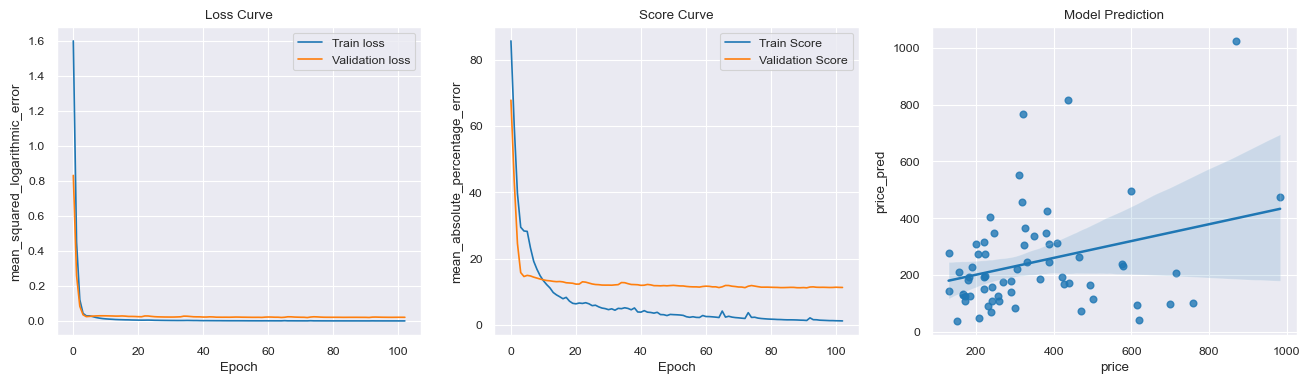

2/2 [==============================] - 0s 1ms/step
R2 Score: -0.6923019972952376
MAPE Score: 0.46615734871904896


In [ ]:
# Train Neural Network
y_log = True
model, history, X_test, y_test, best_time = train_model(X, y, neurons=32, n_init=1, loss='mean_squared_logarithmic_error', opt='adam', learning_rate=0.01, y_log=y_log)

# Evaluate Neural Network
y_pred = model.predict(X_test)
if y_log:
    y_pred = np.exp(y_pred)
r2 = r2_score(y_test, y_pred)
print(f'R2 Score: {r2}')
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE Score: {mape}')

### Hyperparameters Tuning

In [ ]:
neurons = [16, 32, 64, 128, 256]
layers = [1, 2, 3, 4]
opts = ['adam', 'sgd']
learning_rates = [0.1, 0.01, 0.001]
losses = ['mean_squared_logarithmic_error', 'mse', 'mean_absolute_percentage_error']
y_logs = [True, False]
total = len(neurons) * len(layers) * len(opts) * len(learning_rates) * len(losses) * len(y_logs)

In [ ]:
def grid_search(neurons, layers, opts, learning_rates, losses, y_logs, n_init):
    total = len(neurons) * len(layers) * len(opts) * len(learning_rates) * len(losses) * len(y_logs)
    data = []
    best_params = None
    best_mape = 100
    for n, l, o, lr, lo, yl in tqdm(product(neurons, layers, opts, learning_rates, losses, y_logs), total=total):
        if l == 'mean_squared_logarithmic_error' and o == 'sgd':
            continue
        # Train Neural Network
        model, history, X_test, y_test, best_time = train_model(X, y, n_init=n_init, y_log=yl,
                                                                neurons=n, layers=l, opt=o, learning_rate=lr, loss=lo,
                                                                plot=False, print_inits=False)

        # Evaluate Neural Network
        try:
            y_pred = model.predict(X_test, verbose=0)
            if yl:
                y_pred = np.exp(y_pred)
            r2 = r2_score(y_test, y_pred)
            mape = mean_absolute_percentage_error(y_test, y_pred)
        except:
            continue
        
        # Save params and results
        epochs = len(history.epoch)
        params = {'model' : model, 'history' : history, 'neurons': n, 'layers': l, 'optimizer': o, 
                'learning_rate': lr, 'loss': lo, 'y_log' : yl, 'r2_score' : r2, 'mape' : mape, 'time' : best_time, 'epochs' : epochs}
        data.append(params)

        if mape < best_mape:
            best_mape = mape
            best_params = params
    
    # Create DF
    df = pd.DataFrame(data)
    
    return best_params, df

In [16]:
neurons = [16, 32, 64, 128, 256]
layers = [1, 2, 3]
opts = ['adam', 'sgd']
learning_rates = [0.1, 0.01, 0.001]
losses = ['mean_squared_logarithmic_error', 'mse', 'mean_absolute_percentage_error']
y_logs = [True, False]
total = len(neurons) * len(layers) * len(opts) * len(learning_rates) * len(losses) * len(y_logs)

data = []
best_params = None
best_mape = 100
for n, l, o, lr, lo, yl in tqdm(product(neurons, layers, opts, learning_rates, losses, y_logs), total=total):
    if l == 'mean_squared_logarithmic_error' and o == 'sgd':
        continue
    # Train Neural Network
    model, history, X_test, y_test, best_time = train_model(X, y, n_init=1, y_log=yl,
                                                            neurons=n, layers=l, opt=o, learning_rate=lr, loss=lo,
                                                            plot=False, print_inits=False)

    # Evaluate Neural Network
    try:
        y_pred = model.predict(X_test, verbose=0)
        if yl:
            y_pred = np.exp(y_pred)
        r2 = r2_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
    except:
        continue
    
    # Save params and results
    epochs = len(history.epoch)
    params = {'model' : model, 'history' : history, 'neurons': n, 'layers': l, 'optimizer': o, 
              'learning_rate': lr, 'loss': lo, 'y_log' : yl, 'r2_score' : r2, 'mape' : mape, 'time' : best_time, 'epochs' : epochs}
    data.append(params)

    if mape < best_mape:
        best_mape = mape
        best_params = params

100%|██████████| 540/540 [48:20<00:00,  5.37s/it]  


In [18]:
# Show 10 best results
df = pd.DataFrame(data)
df.sort_values(by='mape', ascending=True).head(20)

,model,history,neurons,layers,optimizer,learning_rate,loss,y_log,r2_score,mape,time,epochs
305,<keras.src.engine.sequential.Sequential object...,<keras.src.callbacks.History object at 0x3c500...,64,3,adam,0.001,mean_absolute_percentage_error,False,0.381536,0.209151,3.206817,184
521,<keras.src.engine.sequential.Sequential object...,<keras.src.callbacks.History object at 0x48cff...,256,3,adam,0.001,mean_absolute_percentage_error,False,0.363550,0.210934,4.880737,208
299,<keras.src.engine.sequential.Sequential object...,<keras.src.callbacks.History object at 0x3bcec...,64,3,adam,0.010,mean_absolute_percentage_error,False,0.278414,0.215055,2.190056,113
413,<keras.src.engine.sequential.Sequential object...,<keras.src.callbacks.History object at 0x42c79...,128,3,adam,0.001,mean_absolute_percentage_error,False,0.291233,0.215057,3.408711,153
293,<keras.src.engine.sequential.Sequential object...,<keras.src.callbacks.History object at 0x3b476...,64,3,adam,0.100,mean_absolute_percentage_error,False,0.309140,0.220037,2.231918,113
539,<keras.src.engine.sequential.Sequential object...,<keras.src.callbacks.History object at 0x4ab6a...,256,3,sgd,0.001,mean_absolute_percentage_error,False,0.411248,0.220175,9.824511,497
515,<keras.src.engine.sequential.Sequential object...,<keras.src.callbacks.History object at 0x48d19...,256,3,adam,0.010,mean_absolute_percentage_error,False,0.355305,0.227658,10.675798,89
155,<keras.src.engine.sequential.Sequential object...,<keras.src.callbacks.History object at 0x33d61...,32,2,adam,0.010,mean_absolute_percentage_error,False,0.333128,0.229204,2.109807,130
323,<keras.src.engine.sequential.Sequential object...,<keras.src.callbacks.History object at 0x3d808...,64,3,sgd,0.001,mean_absolute_percentage_error,False,0.180364,0.232407,8.352494,625
173,<keras.src.engine.sequential.Sequential object...,<keras.src.callbacks.History object at 0x34b6e...,32,2,sgd,0.010,mean_absolute_percentage_error,False,0.233985,0.233407,1.807892,118


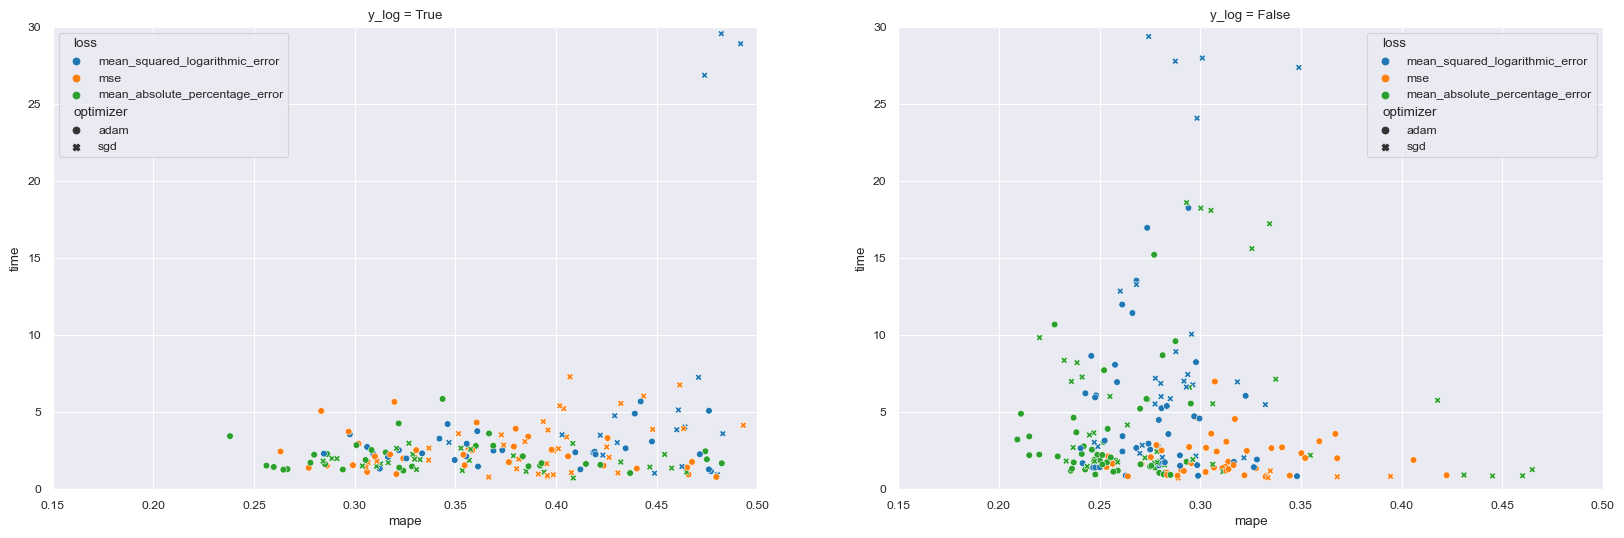

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
plt.subplot(121)
sns.scatterplot(data=df[df.y_log == True], x='mape', y='time', hue='loss', style='optimizer')
plt.title('y_log = True')
plt.axis([0.15, 0.5, 0, 30])

plt.subplot(122)
sns.scatterplot(data=df[df.y_log == False], x='mape', y='time', hue='loss', style='optimizer')
plt.title('y_log = False')
plt.axis([0.15, 0.5, 0, 30]);

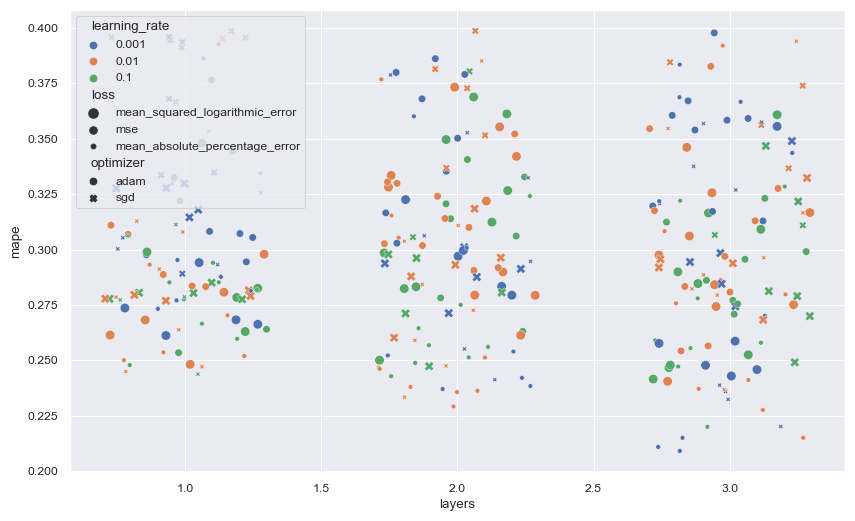

In [40]:
jitter_amount = 0.3  # Adjust this value to control the amount of jittering
x_ = df.layers
y_ = df.mape
x_jittered = x_ + np.random.uniform(-jitter_amount, jitter_amount, len(x_))
# y_jittered = y_ + np.random.uniform(-jitter_amount, jitter_amount, len(y_))

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=df[df.mape < .4], x=x_jittered, y=y_, hue='learning_rate', style='optimizer', size='loss', palette='deep');

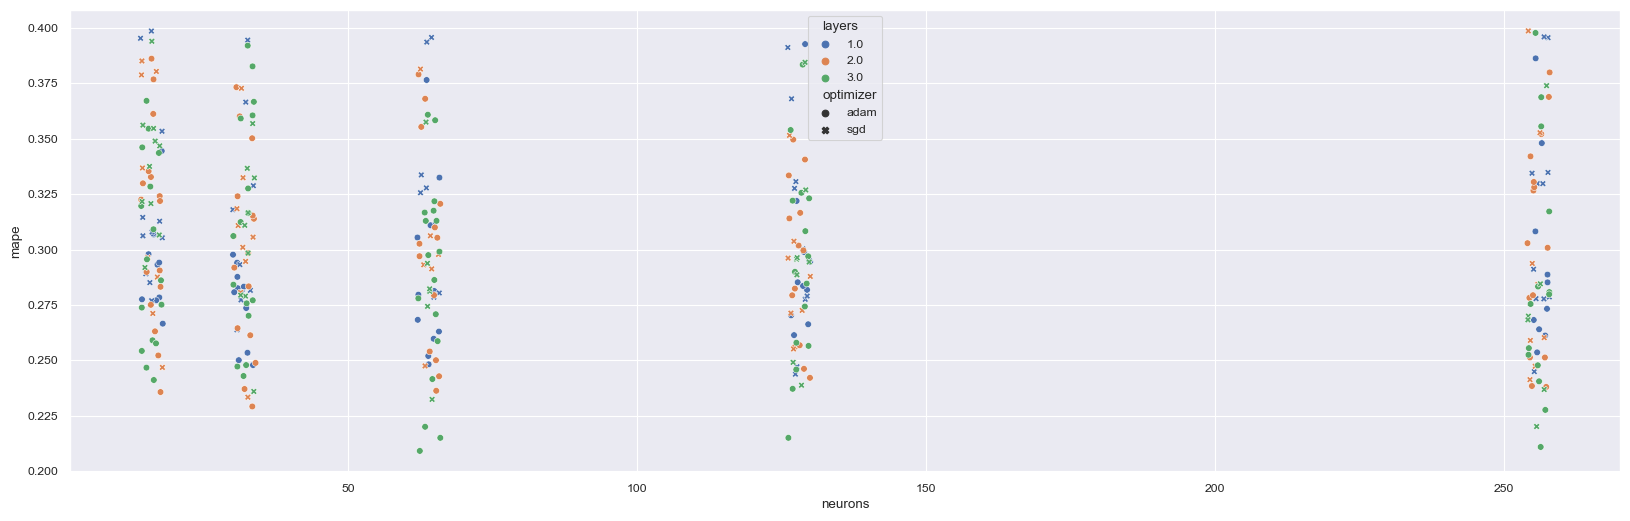

In [47]:
jitter_amount = 2  # Adjust this value to control the amount of jittering
x_ = df.neurons
y_ = df.mape
x_jittered = x_ + np.random.uniform(-jitter_amount, jitter_amount, len(x_))
# y_jittered = y_ + np.random.uniform(-jitter_amount, jitter_amount, len(y_))

fig, ax = plt.subplots(figsize=(20, 6))
sns.scatterplot(data=df[df.mape < .4], x=x_jittered, y=y_, hue='layers', style='optimizer', palette='deep');

In [4]:
neurons = [64, 128, 256, 512]
layers = [3, 4, 5]
opts = ['adam']
learning_rates = [0.1, 0.01, 0.001, 0.0001]
losses = ['mean_absolute_percentage_error']
y_logs = [False]

best_params, df2 = grid_search(neurons, layers, opts, learning_rates, losses, y_logs, n_init=3)

NameError: name 'grid_search' is not defined

In [50]:
df2.sort_values(by='mape', ascending=True).head(10)

,model,history,neurons,layers,optimizer,learning_rate,loss,y_log,r2_score,mape,time,epochs
14,<keras.src.engine.sequential.Sequential object...,<keras.src.callbacks.History object at 0x4c30b...,128,3,adam,0.001,mean_absolute_percentage_error,False,0.451330,0.202999,4.192751,191
6,<keras.src.engine.sequential.Sequential object...,<keras.src.callbacks.History object at 0x4b6a3...,64,4,adam,0.001,mean_absolute_percentage_error,False,0.228786,0.221391,5.009412,223
41,<keras.src.engine.sequential.Sequential object...,<keras.src.callbacks.History object at 0x4797c...,512,4,adam,0.010,mean_absolute_percentage_error,False,0.379355,0.222049,4.470142,73
21,<keras.src.engine.sequential.Sequential object...,<keras.src.callbacks.History object at 0x4cce9...,128,5,adam,0.010,mean_absolute_percentage_error,False,0.394636,0.227187,3.859618,126
5,<keras.src.engine.sequential.Sequential object...,<keras.src.callbacks.History object at 0x4b447...,64,4,adam,0.010,mean_absolute_percentage_error,False,0.258352,0.227234,3.623041,145
29,<keras.src.engine.sequential.Sequential object...,<keras.src.callbacks.History object at 0x4d658...,256,4,adam,0.010,mean_absolute_percentage_error,False,0.286551,0.227716,4.481249,110
13,<keras.src.engine.sequential.Sequential object...,<keras.src.callbacks.History object at 0x4c23b...,128,3,adam,0.010,mean_absolute_percentage_error,False,0.224509,0.231259,3.445297,134
2,<keras.src.engine.sequential.Sequential object...,<keras.src.callbacks.History object at 0x4af65...,64,3,adam,0.001,mean_absolute_percentage_error,False,0.222250,0.232361,4.025474,187
18,<keras.src.engine.sequential.Sequential object...,<keras.src.callbacks.History object at 0x4c7d6...,128,4,adam,0.001,mean_absolute_percentage_error,False,0.155403,0.232496,4.042096,145
22,<keras.src.engine.sequential.Sequential object...,<keras.src.callbacks.History object at 0x4ce10...,128,5,adam,0.001,mean_absolute_percentage_error,False,0.298769,0.233367,5.330617,199


### Melhor Resultado com 15 inits

In [36]:
best_params

{'model': <keras.src.engine.sequential.Sequential at 0x4a5cba990>,
 'history': <keras.src.callbacks.History at 0x4ac9d6310>,
 'neurons': 256,
 'layers': 3,
 'optimizer': 'sgd',
 'learning_rate': 0.001,
 'loss': 'mean_absolute_percentage_error',
 'y_log': False,
 'r2_score': 0.3732664514457392,
 'mape': 0.21475187856248185,
 'time': 10.330493927001953,
 'epochs': 490}


BEST MODEL: 64 Neurons | 2 Layers | Optimizer: adam | Learning Rate: 0.1 | Loss: mse
Init 0 | MAPE Score: 4.82% | Time: 3.8259s
Init 1 | MAPE Score: 100.00% | Time: 1.2529s
Init 2 | MAPE Score: 100.00% | Time: 1.3158s
Init 3 | MAPE Score: 100.00% | Time: 1.2015s
Init 4 | MAPE Score: 100.00% | Time: 1.5584s
Init 5 | MAPE Score: 100.00% | Time: 1.3333s
Init 6 | MAPE Score: 100.00% | Time: 1.2481s
Init 7 | MAPE Score: 100.00% | Time: 1.4856s
Init 8 | MAPE Score: 100.00% | Time: 1.2300s
Init 9 | MAPE Score: 100.00% | Time: 1.1371s
Init 10 | MAPE Score: 100.00% | Time: 1.1833s
Init 11 | MAPE Score: 100.00% | Time: 1.2168s
Init 12 | MAPE Score: 100.00% | Time: 1.1859s
Init 13 | MAPE Score: 100.00% | Time: 25.5774s
Init 14 | MAPE Score: 100.00% | Time: 1.0017s


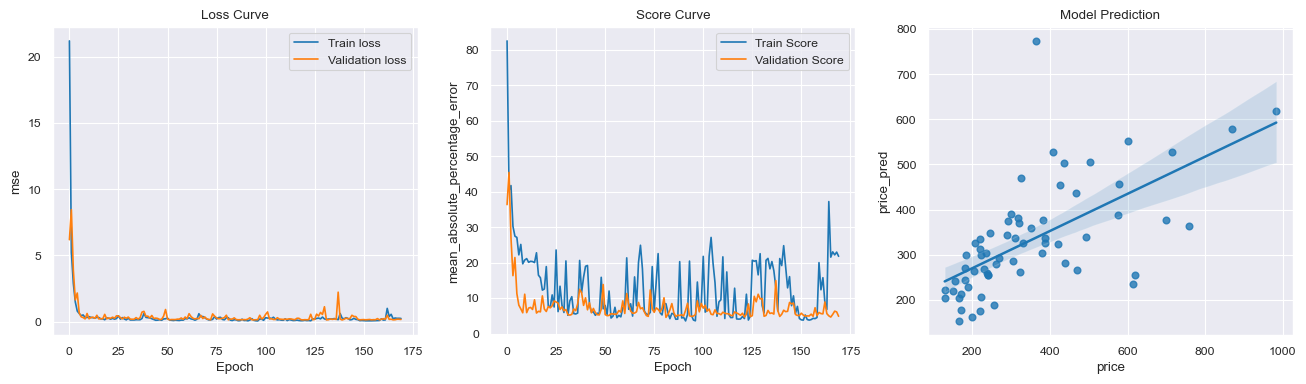

In [98]:
# Evaluate Neural Network
print(f'\nBEST MODEL: {best_params["neurons"]} Neurons | {best_params["layers"]} Layers | \
Optimizer: {best_params["optimizer"]} | Learning Rate: {best_params["learning_rate"]} | Loss: {best_params["loss"]}')

model, history, X_test, y_test, best_time = train_model(X, y,  n_init=15, y_log=best_params['y_log'],
                                                        neurons=best_params['neurons'], layers=best_params['layers'], 
                                                        opt=best_params['optimizer'], learning_rate=best_params['learning_rate'],
                                                        loss=best_params['loss'])

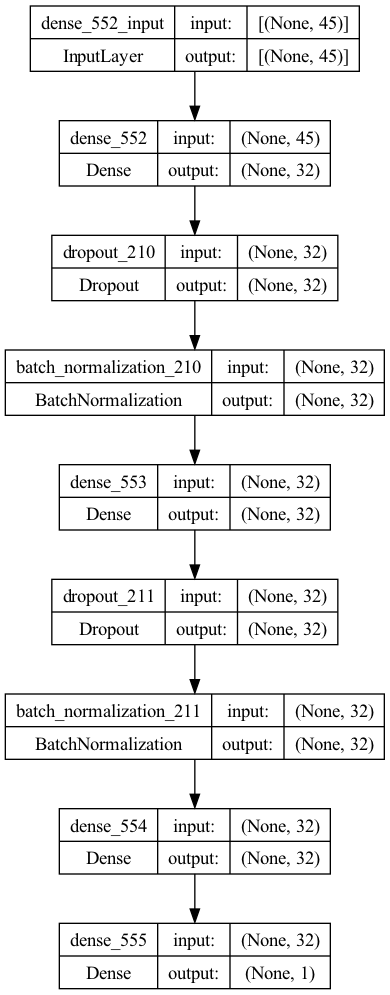

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "sequential_171"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_552 (Dense)           (None, 32)                1472      
                                                                 
 dropout_210 (Dropout)       (None, 32)                0         
                                                                 
 batch_normalization_210 (B  (None, 32)                128       
 atchNormalization)                                              
                                                                 
 dense_553 (Dense)           (None, 32)                1056      
                                                                 
 dropout_211 (Dropout)       (None, 32)                0         
                                                                 
 batch_normalization_211 (B  (None, 32)                128       
 atchNormalization)                                 